In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature

IMG_PATH = "C:\\Users\\Huy\\PythonMining\\ImageProcessing\\C3\\dog1.png"

# Hàm tính ngưỡng Gaussian dựa trên trung vị và độ lệch chuẩn
def get_gaussian_thresholds(image):
    v = np.median(image)
    sigma = np.std(image) # Độ lệch chuẩn của ảnh 
    
    # Ngưỡng dưới = Trung vị - Độ lệch chuẩn
    lower = int(max(0, v - sigma))
    # Ngưỡng trên = Trung vị + Độ lệch chuẩn
    upper = int(min(255, v + sigma))
    
    return lower, upper, sigma

# Hàm hiển thị ảnh nhanh
def show_images(titles, images, figsize=(14, 6)):
    plt.figure(figsize=figsize)
    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, len(images), i+1)
        cmap = 'gray' if len(img.shape) == 2 else None
        plt.imshow(img, cmap=cmap)
        plt.title(title, fontsize=11, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Ngưỡng tính toán: 60 - 173


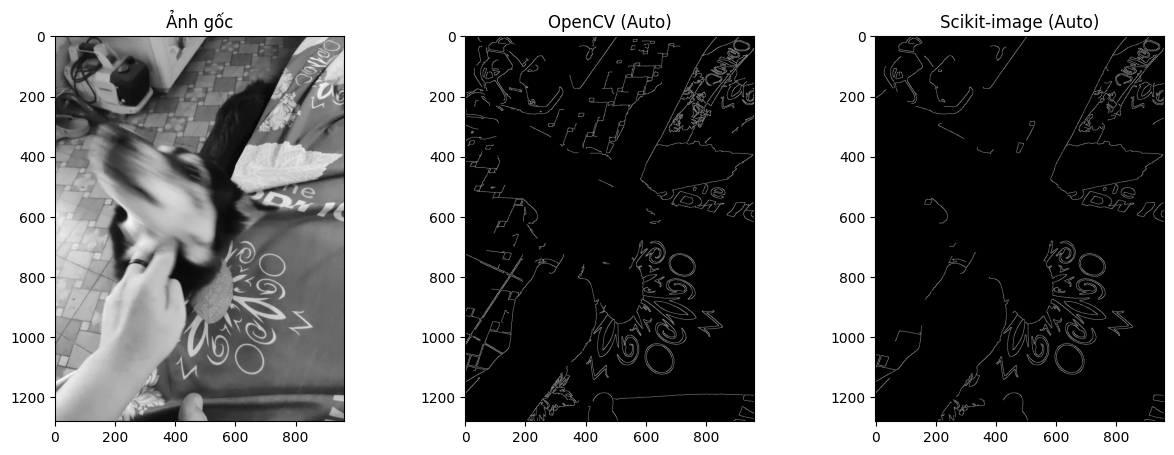

In [59]:
img = cv2.imread(IMG_PATH, 0) # Đọc ảnh xám (2 chiều)

if img is None:
    print("Lỗi: Không tìm thấy ảnh!")
else:
    # Đảm bảo ảnh là 2 chiều
    if len(img.shape) == 3:
        img = img.squeeze()
    
    # Lấy 3 giá trị từ hàm
    low_calc, high_calc, sigma_img = get_gaussian_thresholds(img)
    
    print(f"Ngưỡng tính toán: {low_calc} - {high_calc}")

    # A. OpenCV 
    canny_cv = cv2.Canny(img, low_calc, high_calc)

    # B. Scikit-Image (
    canny_ski = feature.canny(img, sigma=1.0, low_threshold=low_calc, high_threshold=high_calc)
    canny_ski_visible = canny_ski.astype(np.uint8) * 255
    # 3. HIỂN THỊ
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Ảnh gốc")
    
    plt.subplot(1, 3, 2)
    plt.imshow(canny_cv, cmap='gray')
    plt.title(f"OpenCV (Auto)")
    
    plt.subplot(1, 3, 3)
    plt.imshow(canny_ski_visible, cmap='gray')
    plt.title(f"Scikit-image (Auto)")
    
    plt.show()

--> Task 2 (Raw): Std=56.01 -> Ngưỡng 60-173
--> Task 2 (Blur Sigma=1): Std=55.60 (Giảm do mờ) -> Ngưỡng 61-172
--> Task 2 (Blur Sigma=2): Std=54.88 (Giảm do mờ) -> Ngưỡng 63-172


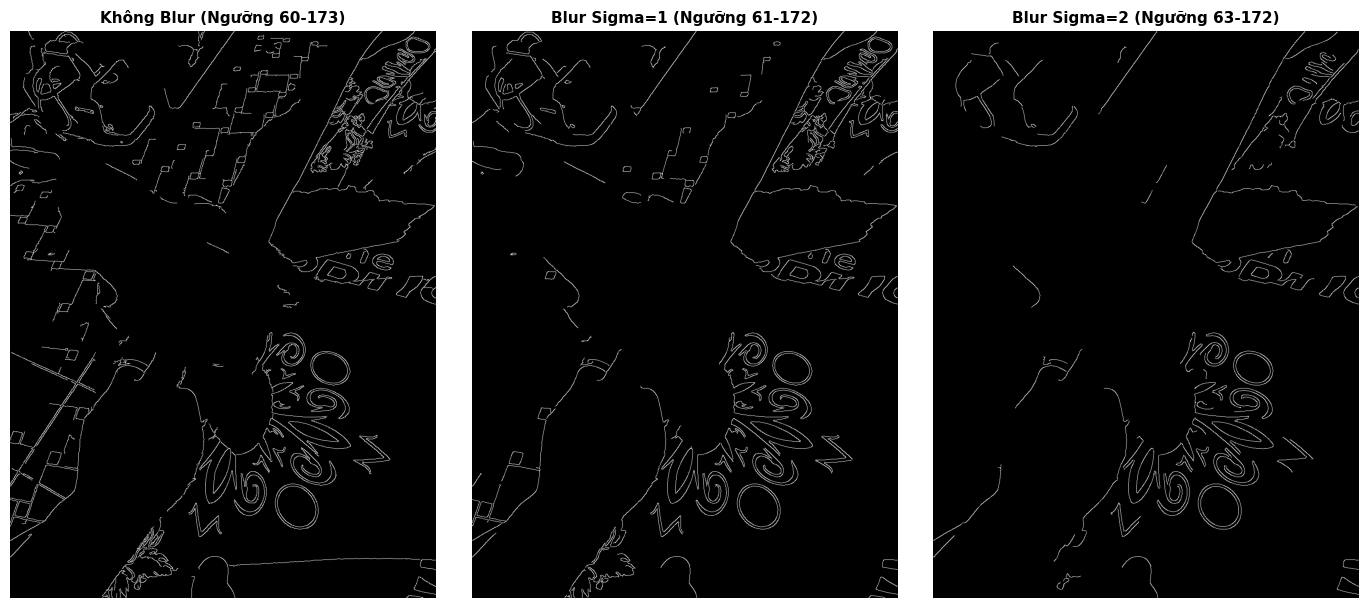

In [60]:
# --- TASK 2: THAY ĐỔI ĐỘ MỜ (SIGMA CỦA BỘ LỌC) ---

# Trường hợp 1: Không làm mờ (Sigma=0) n
l0, h0, _ = get_gaussian_thresholds(img)
canny_raw = cv2.Canny(img, l0, h0)
print(f"--> Task 2 (Raw): Std={np.std(img):.2f} -> Ngưỡng {l0}-{h0}")

# Trường hợp 2: Làm mờ nhẹ (Sigma=1.0)
img_blur_strong = cv2.GaussianBlur(img, (0, 0), sigmaX=1.0)
l1 , h1, std1 = get_gaussian_thresholds(img_blur_strong)
print(f"--> Task 2 (Blur Sigma=1): Std={std1:.2f} (Giảm do mờ) -> Ngưỡng {l1}-{h1}")
canny_blur = cv2.Canny(img_blur_strong, l1, h1)


# Trường hợp 3: Làm mờ mạnh (Sigma=2.0) 
img_blur_strong = cv2.GaussianBlur(img, (0, 0), sigmaX=2.0)
l2, h2, std2 = get_gaussian_thresholds(img_blur_strong)
print(f"--> Task 2 (Blur Sigma=2): Std={std2:.2f} (Giảm do mờ) -> Ngưỡng {l2}-{h2}")

canny_blur2 = cv2.Canny(img_blur_strong, l2, h2)

show_images(
    [f"Không Blur (Ngưỡng {l0}-{h0})", f"Blur Sigma=1 (Ngưỡng {l1}-{h1})", f"Blur Sigma=2 (Ngưỡng {l2}-{h2})"],
    [canny_raw, canny_blur, canny_blur2]
)

--> Ảnh Nhiễu (StdDev cao = 33.67): Khoảng ngưỡng TỰ MỞ RỘNG: 168-235
--> Ảnh Tối   (StdDev thấp = 28.01): Khoảng ngưỡng TỰ CO LẠI : 29-86


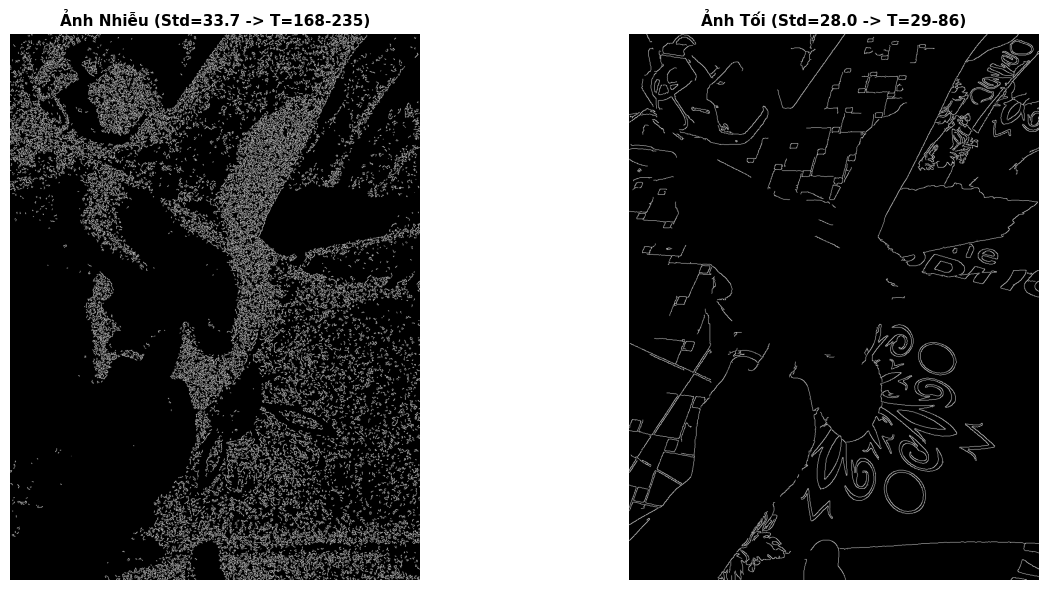

In [61]:
# --- TASK 3: TỰ ĐỘNG THÍCH NGHI VỚI ẢNH XẤU (SỬ DỤNG GAUSSIAN STATS) ---
img = cv2.imread(IMG_PATH, 0) # Đọc ảnh xám (2 chiều)

# Tạo nhiễu Gaussian
noise = np.random.normal(0, 30, img.shape).astype(np.uint8)
img_noisy = cv2.add(img, noise)
# --- A. Ảnh Nhiễu (Noisy Image) ---
# Bắt buộc phải Blur để khử nhiễu (Bước tiền xử lý chuẩn)
img_noisy_blur = cv2.GaussianBlur(img_noisy, (5, 5), 0)
ln, hn, std_n = get_gaussian_thresholds(img_noisy_blur)

print(f"--> Ảnh Nhiễu (StdDev cao = {std_n:.2f}): Khoảng ngưỡng TỰ MỞ RỘNG: {ln}-{hn}")
canny_noisy = cv2.Canny(img_noisy_blur, ln, hn)


# --- B. Ảnh Tương Phản Thấp (Low Contrast) ---
# Làm ảnh tối đi 50% -> Độ lệch chuẩn (StdDev) sẽ giảm đi một nửa
img_low = (img * 0.5).astype(np.uint8)

# Bước 3: Tính ngưỡng dựa trên thống kê Gaussian
ll, hl, std_l = get_gaussian_thresholds(img_low)

print(f"--> Ảnh Tối   (StdDev thấp = {std_l:.2f}): Khoảng ngưỡng TỰ CO LẠI : {ll}-{hl}")
# Giải thích: Vì ảnh tối, histogram hẹp lại -> StdDev nhỏ -> Ngưỡng co lại để bắt cạnh yếu tốt hơn

canny_low = cv2.Canny(img_low, ll, hl)

show_images(
    [f"Ảnh Nhiễu (Std={std_n:.1f} -> T={ln}-{hn})", f"Ảnh Tối (Std={std_l:.1f} -> T={ll}-{hl})"],
    [canny_noisy, canny_low]
)

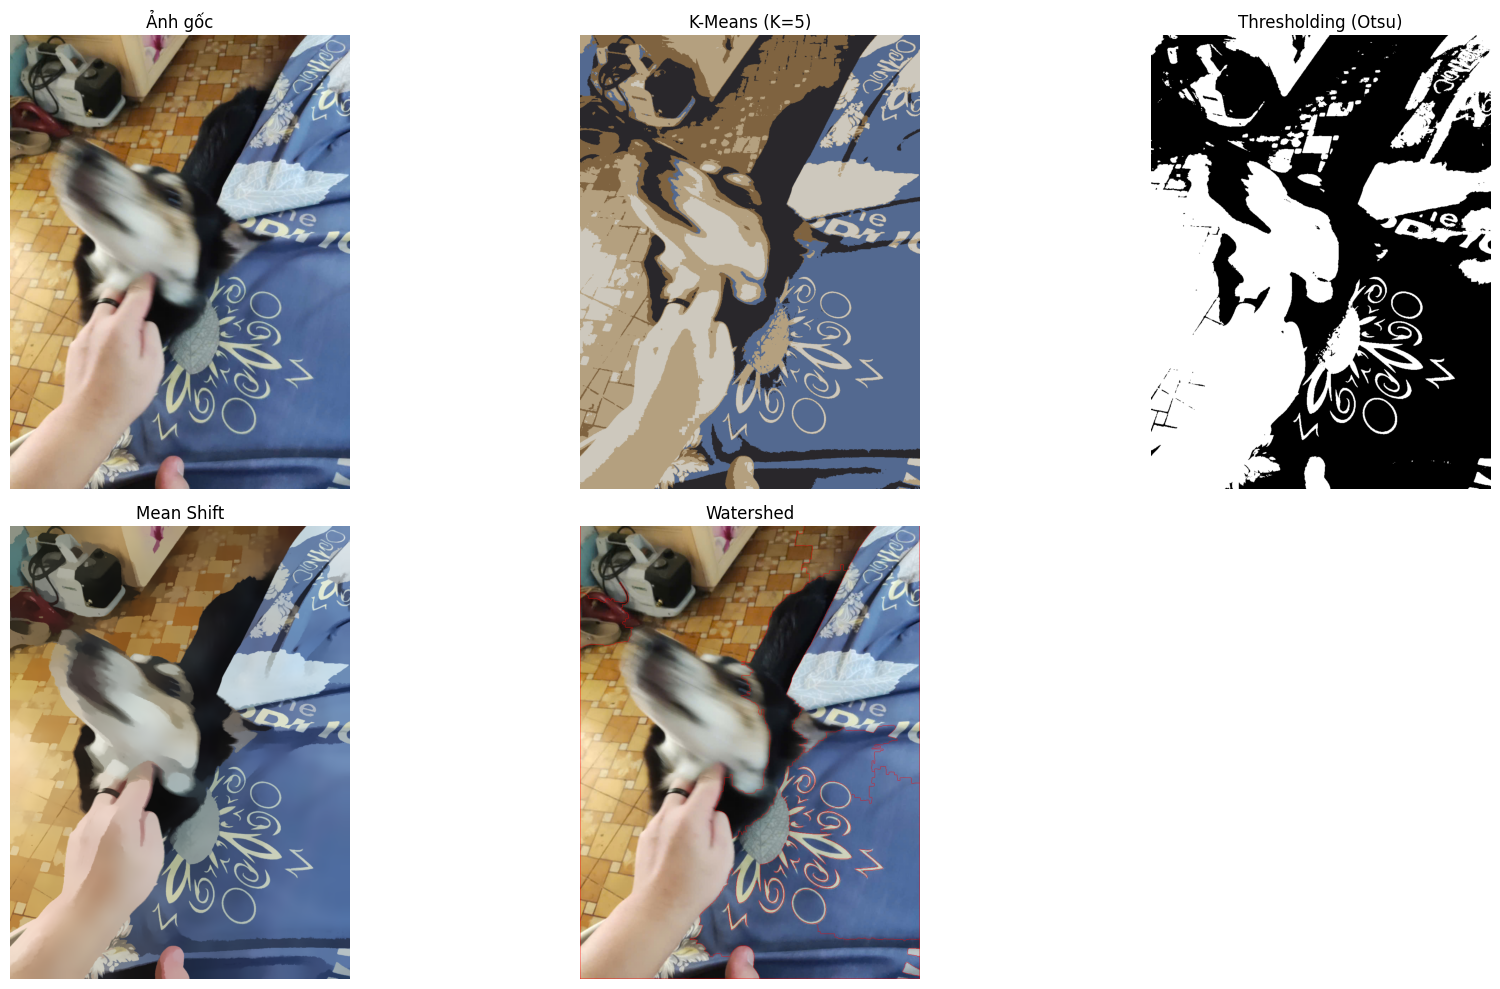

In [ ]:
# --- TASK 4: SO SÁNH CÁC PHƯƠNG PHÁP PHÂN ĐOẠN ẢNH ---
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH)
if img is None:
    raise ValueError("Không đọc được ảnh, kiểm tra lại IMG_PATH")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# =========================
# 1. K-MEANS SEGMENTATION
# =========================
pixel_values = img.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 5

_, labels, centers = cv2.kmeans(
    pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
)

centers = np.uint8(centers)
segmented_kmeans = centers[labels.flatten()].reshape(img.shape)

# =========================
# 2. THRESHOLDING (OTSU)
# =========================
_, segmented_otsu = cv2.threshold(
    gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# =========================
# 3. MEAN SHIFT
# =========================
segmented_meanshift = cv2.pyrMeanShiftFiltering(
    img, sp=20, sr=30
)

# =========================
# 4. WATERSHED
# =========================
blur = cv2.GaussianBlur(gray, (5, 5), 0)

_, thresh = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(
    dist_transform, 0.5 * dist_transform.max(), 255, 0
)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)

segmented_watershed = img.copy()
segmented_watershed[markers == -1] = [255, 0, 0]  # viền đỏ

# =========================
# HIỂN THỊ KẾT QUẢ
# =========================
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(segmented_kmeans)
plt.title("K-Means (K=5)")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(segmented_otsu, cmap="gray")
plt.title("Thresholding (Otsu)")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(segmented_meanshift)
plt.title("Mean Shift")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(segmented_watershed)
plt.title("Watershed")
plt.axis("off")

plt.tight_layout()
plt.show()


Đã phát hiện và đóng khung 10 đối tượng.


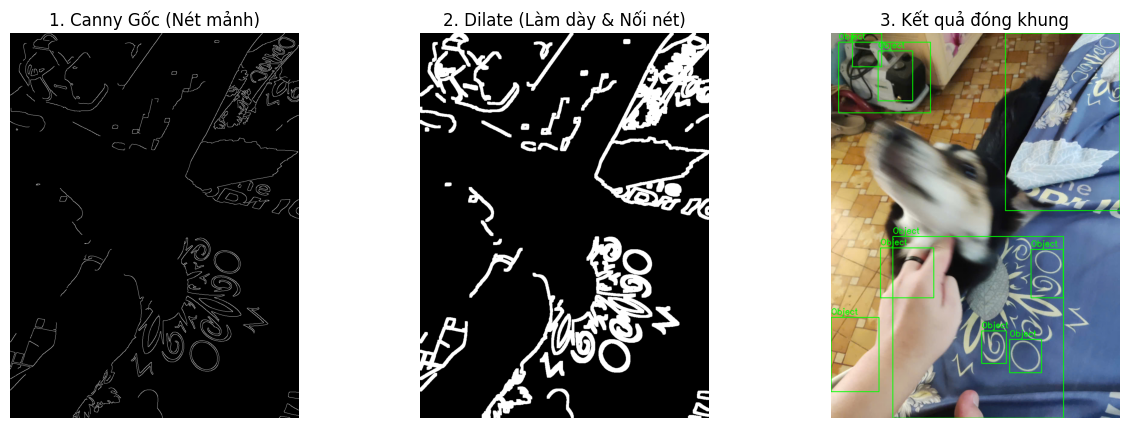

In [ ]:
# --- TASK 5: PHÁT HIỆN VÀ ĐÓNG KHUNG ĐỐI TƯỢNG SỬ DỤNG CANNY VÀ CONTOURS ---
img = cv2.imread(IMG_PATH)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# 2. Áp dụng CANNY
lower, upper,_ = get_gaussian_thresholds(blur)
edges = cv2.Canny(blur, lower, upper)

# 3. DILATION (Làm dày nét)
# Canny cho nét rất mảnh và hay bị đứt đoạn.
# Ta cần làm nó "phình" ra để các nét đứt dính lại thành một khối liền mạch.
kernel = np.ones((5, 5), np.uint8)
edges_thick = cv2.dilate(edges, kernel, iterations=2) 
# (iterations=2 để phình to gấp đôi, dễ dính các cạnh lại với nhau)

# 4. Tìm Contours (Chỉ lấy viền ngoài cùng)
contours, _ = cv2.findContours(edges_thick, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 5. Vẽ khung chữ nhật
img_result = img.copy()
count = 0

for cnt in contours:
    # Lọc rác: Chỉ lấy vùng có diện tích lớn (bỏ qua mấy hạt nhiễu nhỏ)
    area = cv2.contourArea(cnt)
    if area > 4000:
        count += 1
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img_result, "Object", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

print(f"Đã phát hiện và đóng khung {count} đối tượng.")

# 6. Hiển thị
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(edges, cmap='gray')
plt.title("1. Canny Gốc (Nét mảnh)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges_thick, cmap='gray')
plt.title("2. Dilate (Làm dày & Nối nét)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.title("3. Kết quả đóng khung")
plt.axis('off')

plt.show()